In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

##Step 1: Explore Plant Trait-Trait Similarities

In [ ]:
# Data loading
df_to = pd.read_pickle("/content/drive/MyDrive/Projects/semantic_alignment_ontology/data/to_embeddings.pkl")

In [ ]:
# List all trait names
print(list(df_to["Label"]))

['carbon sensitivity', 'OBSOLETE epigenetic trait', 'alkali soil sensitivity', 'reversible male sterility', 'calcium sensitivity', 'sulfur sensitivity', 'potassium sensitivity', 'genic male sterility-photoperiod sensitive', 'magnesium sensitivity', 'nitrogen sensitivity', 'hydrogen sensitivity', 'mycoplasma disease response', 'panicle weight', 'oxygen sensitivity', 'cobalt sensitivity', 'plant morphology trait', 'boron sensitivity', 'seedling height', 'black streak dwarf virus resistance', 'copper sensitivity', 'stink bug resistance', 'rice microbial grain discoloration', 'ligule length', 'molybdenum sensitivity', 'aborted tri-nucleate stage', 'culm number', 'unfilled grain number', 'chlorine sensitivity', 'sedge weed response', 'silicon sensitivity', 'selenium sensitivity', 'iodine sensitivity', 'chromium sensitivity', 'incompatibility trait', 'hybrid incompatibility', 'OBSOLETE male sterility extent', 'fluorine sensitivity', 'OBSOLETE yield component', 'panicle length', 'brown rice l

In [ ]:
# Get a sense which traits are semantically close in vector space

# Example: "seed coat hardness" (which has more highly similar/related traits)
target_idx = df_to[df_to["Label"] == "seed coat hardness"].index[0]
target_vec = [df_to.loc[target_idx, "Embedding"]]

# Compute cosine similarity to all others
similarities = cosine_similarity(target_vec, list(df_to["Embedding"]))[0]

# Get top N similar traits
df_to["Similarity"] = similarities
top_matches = df_to.sort_values("Similarity", ascending=False).head(10)
print(top_matches[["Label", "Similarity"]])

                          Label  Similarity
869          seed coat hardness    1.000000
964               seed hardness    0.893988
883           seed coat texture    0.817182
818  seed coat morphology trait    0.783225
884           seed coat pattern    0.775827
186             seed coat color    0.773501
860            seed coat length    0.763768
870        seed coat proportion    0.751165
299              seed thickness    0.728743
868            seed coat luster    0.712207


In [ ]:
# Another example: "days to booting" (which has fewer highly similar/related traits)
target_idx = df_to[df_to["Label"] == "days to booting"].index[0]
target_vec = [df_to.loc[target_idx, "Embedding"]]

# Compute cosine similarity to all others
similarities = cosine_similarity(target_vec, list(df_to["Embedding"]))[0]

# Get top N similar traits
df_to["Similarity"] = similarities
top_matches = df_to.sort_values("Similarity", ascending=False).head(10)
print(top_matches[["Label", "Similarity"]])

                                           Label  Similarity
1037                             days to booting    1.000000
338                      days to flowering trait    0.694182
1143                        flowering time trait    0.599615
1464                           days to germinate    0.585268
459                             days to maturity    0.579774
358                     reproductive growth time    0.542268
914   photoperiod-sensitive flowering time trait    0.516456
143                                  seed length    0.514172
361                       vegetative growth time    0.499914
451                       basic vegetative phase    0.475533


##Step 2: Visualise Trait Clustering using PCA/TSNE and K-Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the embedding matrix
X = np.vstack(df_to["Embedding"].values)

silhouette_scores = []
k_range = range(5, 100)
best_score = -1
best_k = None
best_model = None
best_labels = None

for k in k_range:
  # compute kmeans and silhouette (fitness) score
  km = KMeans(n_clusters=k, random_state=42, n_init=10)
  labels = km.fit_predict(X)
  score = silhouette_score(X, labels)
  silhouette_scores.append(score)

  if score > best_score: # gradually finding and recording the best score over cluster size
      best_score = score
      best_k = k
      best_model = km
      best_labels = labels

print(f"\n Best cluster count: {best_k} (silhouette = {best_score:.3f})")


 Best cluster count: 98 (silhouette = 0.105)


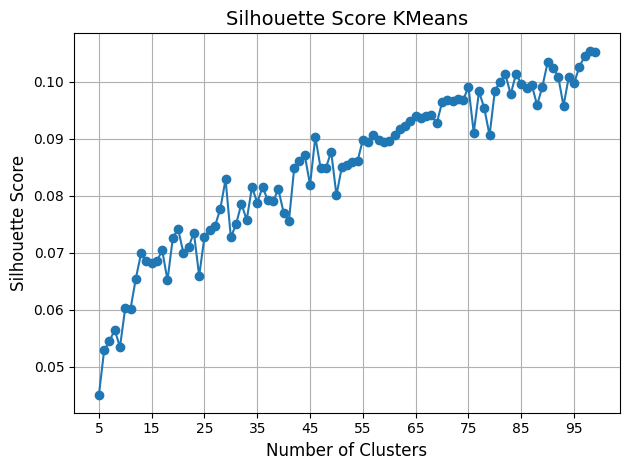

In [ ]:
# Plot silhouette across cluster number
plt.figure()
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.title("Silhouette Score KMeans", fontsize=14)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)

xtick_positions = np.arange(min(k_range), max(k_range)+1, 10) # showing only every 10th x-axis tick
plt.xticks(xtick_positions)
plt.grid(True)
plt.tight_layout()
plt.show()

df_to["Cluster"] = best_labels

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

# Run TSNE (2D projection)
X_2d = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto').fit_transform(X)

# KMeans clustering with k=98
k = 98
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_to["Cluster"] = kmeans.fit_predict(X).astype(str)

# Add 2D coordinates to df
df_to["x"] = X_2d[:, 0]
df_to["y"] = X_2d[:, 1]

# Plotly scatter plot
fig = px.scatter(
    df_to,
    x="x", y="y",
    color="Cluster",
    hover_name="Label",
    title=f"TSNE Projection of Trait Embeddings (KMeans k={k})",
    color_discrete_sequence=px.colors.qualitative.Set3,
    width=900, height=600
)

fig.update_traces(marker=dict(size=6, opacity=0.8, line=dict(width=0.5, color='white')))
fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    legend_title_text='Cluster'
)

fig.show()


In [ ]:
# Top 5 labels per cluster
print(f"\nTop 5 representative traits per cluster (k={k}):\n")
centroids = kmeans.cluster_centers_
df_to["EmbeddingArray"] = df_to["Embedding"]  # for safety

for c in range(k):
    members = df_to[df_to["Cluster"] == str(c)].copy()
    center = centroids[c]
    members["DistToCenter"] = members["EmbeddingArray"].apply(lambda x: np.linalg.norm(x - center))
    top_traits = members.sort_values("DistToCenter").head(5)

    print(f"Cluster {c} ({len(members)} terms):")
    for i, row in top_traits.iterrows():
        print(f"   - {row['Label']}")
    print()


Top 5 representative traits per cluster (k=98):

Cluster 0 (10 terms):
   - amylase activity trait
   - alpha-amylase activity trait
   - beta-amylase activity trait
   - total amylase activity trait
   - enzyme activity trait

Cluster 1 (45 terms):
   - nutrient sensitivity
   - non-mineral nutrient sensitivity
   - growth media composition sensitivity
   - macronutrient sensitivity
   - micronutrient sensitivity

Cluster 2 (9 terms):
   - inflorescence presence
   - inflorescence bract cover
   - inflorescence bract number
   - infructescence position
   - involucral bract spine presence

Cluster 3 (24 terms):
   - seed size
   - seed morphology trait
   - seed length
   - seed width
   - seed coat morphology trait

Cluster 4 (25 terms):
   - leaf elongation rate
   - leaf senescence rate
   - leaf senescence duration
   - adaxial stomatal frequency
   - abaxial stomatal frequency

Cluster 5 (24 terms):
   - root system strontium content
   - root system rubidium content
   - root s

Interim conclusion:

In general, categorisation based on K-means gave bad performance. Even with a cluster number of 100, the silhouette socre was quite low (around 0.10).

Based on the plot of categorisation shown above, the embeddings did not form solid, separate clusters. Instead, they, aka meaning, gradually drifted rather than sharply jump (between existing categories).

###Step 2.5: Compress embeddings using PCA and try KMeans again
Rationale:
* Raw embeddings produced straight from the Transformer model have a lot of dimensions (N = 384), which can redundant (and noisy)
* Dimensionality reduction using PCA can help de-noise the embeddings and cut dimensions that do not help with clustering



In [ ]:
from sklearn.decomposition import PCA

# Reduce (from 384D) to 50D using PCA
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X)
print(f"PCA: Reduced from {X.shape[1]}D to {X_pca.shape[1]}D")

silhouette_scores = []
k_range = range(5, 100)
best_score = -1
best_k = None
best_model = None
best_labels = None

for k in k_range:
  # computing kmeans and silhouette (fitness) score
  km = KMeans(n_clusters=k, random_state=42, n_init=10)
  labels = km.fit_predict(X_pca)
  score = silhouette_score(X_pca, labels)
  silhouette_scores.append(score)

  if score > best_score: # gradually finding and recording the best score over cluster size
      best_score = score
      best_k = k
      best_model = km
      best_labels = labels

print(f"\n Best cluster count: {best_k} (silhouette = {best_score:.3f})")

PCA: Reduced from 384D to 50D

 Best cluster count: 94 (silhouette = 0.146)


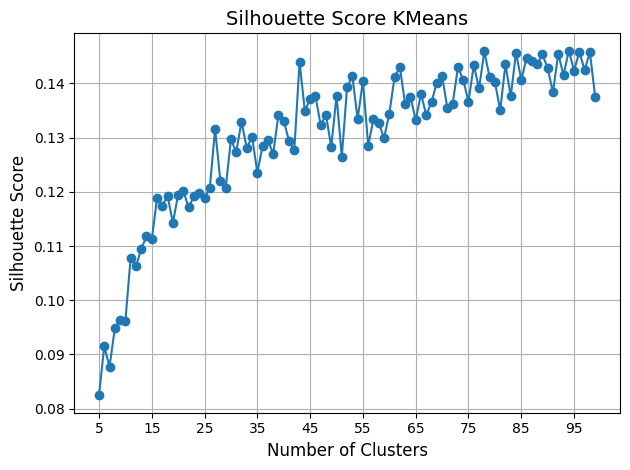

In [ ]:
# Plot silhouette across cluster number
plt.figure()
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.title("Silhouette Score KMeans", fontsize=14)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)

xtick_positions = np.arange(min(k_range), max(k_range)+1, 10) # showing only every 10th x-axis tick
plt.xticks(xtick_positions)
plt.grid(True)
plt.tight_layout()
plt.show()

df_to["Cluster"] = best_labels

In [ ]:
# Run TSNE (2D projection)
X_2d = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto').fit_transform(X_pca)

# K-Means clustering with k=98
k = 94
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_to["Cluster"] = kmeans.fit_predict(X_pca).astype(str)

# Add 2D coordinates to df
df_to["x"] = X_2d[:, 0]
df_to["y"] = X_2d[:, 1]

# Plotly scatter plot
fig = px.scatter(
    df_to,
    x="x", y="y",
    color="Cluster",
    hover_name="Label",
    title=f"TSNE Projection of Trait Embeddings (KMeans k={k}, Vector Dimension {X_pca.shape[1]}D)",
    color_discrete_sequence=px.colors.qualitative.Set3,
    width=900, height=600
)

fig.update_traces(marker=dict(size=6, opacity=0.8, line=dict(width=0.5, color='white')))
fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    legend_title_text='Cluster'
)

fig.show()


Interim conclusion:

After PCA, the embeddings seemed more visually separable, but still were not be grouped tightly enough to score well (Silhouette = 0.146 max,with cluster number k = 98) with cateogrisation/clustering methods based on Euclidean distance like K-Means.

This happened largely because plant trait embeddings are semantically more continuous than sharply separable. Consider for instance _leaf color_, _flower color_, and _plant color_; they are categorised into different clusters by K-Means, but they are closely connected in a conceptual sense.

Note, though, that the main goal of our expedition in the continuous, vector-based semantic space here is to examine the possibility of categorising plant traits—including novel, previously unseen traits not yet captured in the ontology—and ultimately, to generate interpretable descriptions for them. To achieve such a goal, encoding plant traits as distributional vectors is necessary: it allows us to classify and relate concepts based on cosine similarity, opening the door for both semantic categorization and language-based inference.

Therefore, given that the plant trait embeddings are not sharply grouped by nature, a reasonable follow-up here is to apply hierarchical clustering, a method that organizes concepts into nested groupings without assuming rigid separability. This might better reflect the gradient-like nature of semantic similarity in plant traits.



##Step 3: Apply Hierarchical Clustering
Rationale:
* Automatically reveals structure at multiple levels of granularity
* Better suited for plant traits, which often exist on a continuum (e.g., growth, color, resistance)
* Produces a tree (dendrogram) that can be manually inspected and labeled at different levels, supporting expert interpretation

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Trait labels
labels = df_to["Label"].tolist()

# Perform hierarchical clustering (Ward's method preserves variance, i.e. smallest variance within a newly merged cluster)
linked = linkage(X_pca, method='ward') # note that we performed clustering on PCA-ed data, based on K-Means results above

In [ ]:
# Visualisation
# Identify the largest N merging distances
N_MERGE_LINES = 5   # Number of largest merges to mark
top_merges = sorted(linked[:, 2], reverse=True)[:N_MERGE_LINES]

# Plot the dendrogram with vertical lines at top merging distances
plt.figure(figsize=(16, 0.35 * len(labels)))
dendrogram(
    linked,
    labels=labels,
    orientation='left',
    distance_sort='descending',
    show_leaf_counts=False,
    leaf_font_size=8,
)

for d in top_merges:
    plt.axvline(x=d, color='red', linestyle='--', linewidth=1, alpha=0.6)

plt.title("Dendrogram with Major Merge Points (dashed lines)", fontsize=14)
plt.xlabel("Distance")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Print sample traits from clusters formed at each top merging point
print(f"\nTop {N_MERGE_LINES} Merge Points (Distances):")
for i, threshold in enumerate(top_merges, 1):
    flat_clusters = fcluster(linked, t=threshold, criterion='distance')
    df_to[f'Cluster_at_{threshold:.2f}'] = flat_clusters
    print(f"\n--- Merge #{i} at distance {threshold:.2f} → {len(np.unique(flat_clusters))} clusters ---")
    for cid in np.unique(flat_clusters):
        cluster_terms = df_to[df_to[f'Cluster_at_{threshold:.2f}'] == cid]["Label"].head(3).tolist()
        print(f"  Cluster {cid}: {cluster_terms}")


Top 5 Merge Points (Distances):

--- Merge #1 at distance 9.88 → 1 clusters ---
  Cluster 1: ['carbon sensitivity', 'OBSOLETE epigenetic trait', 'alkali soil sensitivity']

--- Merge #2 at distance 8.51 → 2 clusters ---
  Cluster 1: ['carbon sensitivity', 'alkali soil sensitivity', 'calcium sensitivity']
  Cluster 2: ['OBSOLETE epigenetic trait', 'reversible male sterility', 'genic male sterility-photoperiod sensitive']

--- Merge #3 at distance 6.98 → 3 clusters ---
  Cluster 1: ['carbon sensitivity', 'alkali soil sensitivity', 'calcium sensitivity']
  Cluster 2: ['plant morphology trait', 'ligule length', 'stigma exsertion']
  Cluster 3: ['OBSOLETE epigenetic trait', 'reversible male sterility', 'genic male sterility-photoperiod sensitive']

--- Merge #4 at distance 6.63 → 4 clusters ---
  Cluster 1: ['carbon sensitivity', 'alkali soil sensitivity', 'calcium sensitivity']
  Cluster 2: ['plant morphology trait', 'ligule length', 'stigma exsertion']
  Cluster 3: ['black streak dwarf v

Crucial take-away:

Generally, hierarchical clustering yielded a good tree-structure of plant trait labels from bottom up. The Distance of the x-axis tells us how (dis)similar a cluster was to the other when the two cluster merged.

From the tree at least it is clear that highly related traits (e.g., all the traits containing the words _seed_, _leaf_, _sterility_) were merged into one cluster quite early on with a low (dis)similarity distance.

Further validation of the tree structure should be done with the communication with and assistance from experts.